# 09_Model: Xtreme Gradient Boost with extracted features and TFIDF Transformation:

- TFIDF transformation features
- Complexity
- Lexical / stylometric features

In [3]:
import pandas as pd

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')

In [4]:
df.head()

text  n_sents  n_words  \
0  sofía castro y alejandro peña pretelini: una i...        8      252   
1  un paso más cerca de hacer los exámenes 'onlin...        9      486   
2  esto es lo que los científicos realmente piens...       31      980   
3  inicia impresión de boletas para elección pres...       11      369   
4  a *number* día del mundial\nfifa.com sigue la ...        5      130   

   avg_words_sents  word_size  unique_words        ttr       mltd  \
0        31.500000   4.190476     34.920635  50.000000  58.600559   
1        54.000000   4.255144     32.716049  44.238683  41.283136   
2        31.612903   4.815306     26.020408  38.571429  80.551467   
3        33.545455   4.728997     22.764228  37.398374  50.995314   
4        26.000000   4.461538     48.461538  60.000000  47.081602   

   propn_ratio  noun_ratio  adp_ratio  det_ratio  punct_ratio  pron_ratio  \
0    15.079365   15.079365  13.888889  11.507937     9.523810    5.555556   
1    16.666667   15.226337  12.345679  11.111111    18.930041    1.234568   
2     4.795918   17.857143  13.979592  12.755102    11.836735    2.551020   
3     4.065041   22.493225  18.157182  15.176152    11.111111    2.710027   
4    14.615385   14.615385  17.692308  13.846154     9.230769    3.076923   

   verb_ratio  adv_ratio  label  
0    6.349206   3.174603      1  
1    3.292181   1.646091      1  
2   10.306122   4.693878      1  
3    7.317073   0.271003      1  
4    4.615385   1.538462      1

In [6]:
df.shape

(971, 17)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 17 columns):
text               971 non-null object
n_sents            971 non-null int64
n_words            971 non-null int64
avg_words_sents    971 non-null float64
word_size          971 non-null float64
unique_words       971 non-null float64
ttr                971 non-null float64
mltd               971 non-null float64
propn_ratio        971 non-null float64
noun_ratio         971 non-null float64
adp_ratio          971 non-null float64
det_ratio          971 non-null float64
punct_ratio        971 non-null float64
pron_ratio         971 non-null float64
verb_ratio         971 non-null float64
adv_ratio          971 non-null float64
label              971 non-null int64
dtypes: float64(13), int64(3), object(1)
memory usage: 129.1+ KB


In [9]:
df.columns

Index(['text', 'n_sents', 'n_words', 'avg_words_sents', 'word_size',
       'unique_words', 'ttr', 'mltd', 'propn_ratio', 'noun_ratio', 'adp_ratio',
       'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio',
       'label'],
      dtype='object')

## Another grid search

In [5]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

from scipy import stats
from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()


########### Combine features & train, test split ########### 

numerical_features = ['n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
tfvocab = df[numerical_features].columns.tolist() + tfvocab

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB GRID SEARCH ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.01, 0.02],
              'n_estimators': [1000, 1500],
              'max_depth': [6, 9], 
              'subsample': [0.4, 0.8], 
              'colsample_bytree': [0.5, 1],
              'min_child_weight' : [1, 5, 10],
              'lambda': [1, 1.5],
              'alpha': [0, 0.2]}

folds = 3
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 43)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, 
                                   scoring = 'roc_auc', n_jobs = 4, cv = skf.split(X_train, y_train), verbose = 3)

grid_search.fit(X_train, y_train)

########### Grid search results ###########
print('\n Best estimator:')
print(grid_search.best_estimator_)
best_estimator = grid_search.best_estimator_

print('\n Best score:')
print(grid_search.best_score_ * 2 - 1)

print('\n Best parameters:')
print(grid_search.best_params_)

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 33.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 51.9min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 76.3min
[Parallel(n_jobs=4)]: Done 1152 out of 1152 | elapsed: 76.7min finished



 Best estimator:
XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1, learning_rate=0.02,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.9775967413441956, seed=43, subsample=0.4,
              tree_method='exact', validate_parameters=1, ...)

 Best score:
0.8160071091105572

 Best parameters:
{'alpha': 0, 'colsample_bytree': 0.5, 'lambda': 1, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.4}


# Full model

In [3]:
df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
df.columns

Index(['text', 'headline', 'n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Testing AUC: 0.889624


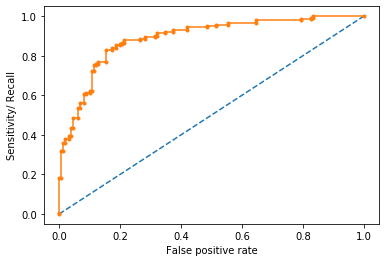

Logloss: 5.80
Accuracy: 83.22


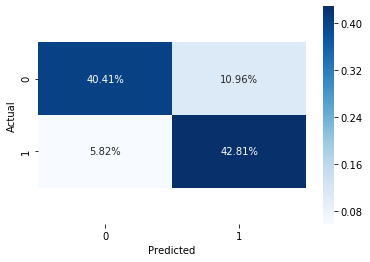

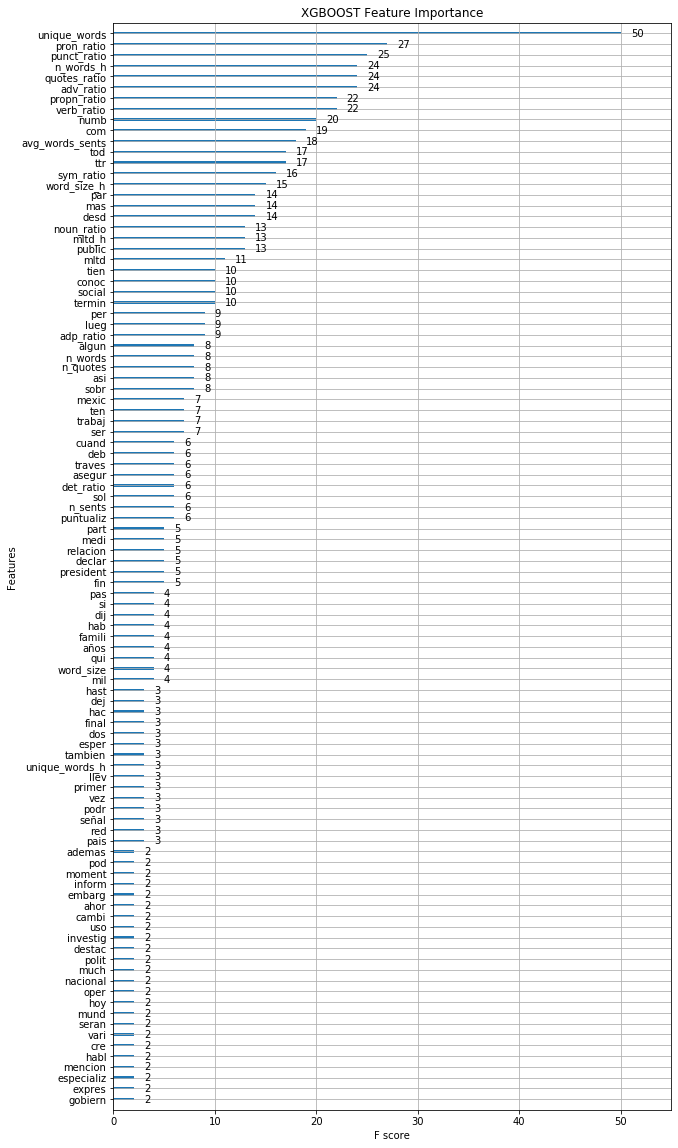

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

from scipy import stats
from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()


########### Combine features & train, test split ########### 

numerical_features = ['n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
tfvocab = df[numerical_features].columns.tolist() + tfvocab

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'alpha': 0,
              'colsample_bytree': 0.5,
              'lambda': 1,
              'learning_rate': 0.02,
              'max_depth': 6,
              'min_child_weight': 1,
              'n_estimators': 1000,
              'subsample': 0.4}

xgb_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve

plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (xgb_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();


########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 20])
axsub = xgb.plot_importance(xgb_model, max_num_features = 100, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
lst_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [dict_features[int(i)] for i in lst_yticklabels]

# feature importance
plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(lst_yticklabels)
plt.show()